In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding,  LSTM, Dense, Concatenate 
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, fbeta_score,
                             confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
                             classification_report) 

##### **Load Train and Test Data**

In [8]:
def load_and_prepare_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)

    x_text = df['review_text'].tolist()
    y = df['is_spoiler'].astype(int).values
    meta_features = [
        'rating_x',
        'review_year', 'review_month', 'review_day',
        'duration',
        'polarity', 'subjectivity'
    ]

    # Some features may be missing in some rows → fill
    df_meta = df[meta_features].fillna(0)

    # Convert to numpy array
    x_meta = df_meta.values.astype(np.float32)

    return x_text, x_meta, y

In [9]:
x_train, x_train_meta, y_train = load_and_prepare_data('../data/processed/IMDB_reviews_train_cleaned.json')
x_test, x_test_meta, y_test = load_and_prepare_data('../data/processed/IMDB_reviews_test.json')

##### **Sequence Padding (Oversampling)**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

Max Words

In [9]:
vocab_size = len(tokenizer.word_index)
max_words = int(vocab_size * 0.10)         # Keep top 10%
print("Suggested max_words:", round(max_words, -4))

Suggested max_words: 20000


Max Length

In [10]:
lengths = [len(seq) for seq in x_train_seq]
percentiles = np.percentile(lengths, [50, 75, 90, 95, 99])
print("Suggested max_len:", round(int(percentiles[2]), -2))  # Between 90 - 95 percentile


Suggested max_len: 400


In [11]:
max_words = 20000      # Vocabulary size
max_len = 400          # Max sequence length 

In [12]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [13]:
rus = RandomOverSampler(random_state = 3244)

X_dummy = np.zeros((len(y_train), 1))
_, y_train_resampled = rus.fit_resample(X_dummy, y_train)
idx = rus.sample_indices_
 

In [14]:
x_train_seq_resampled = [x_train_seq[i] for i in idx]
y_train_resampled = y_train[idx]

In [15]:
x_train_padded = pad_sequences(x_train_seq_resampled, maxlen = max_len, padding = 'post', truncating = 'post')
x_test_padded = pad_sequences(x_test_seq, maxlen = max_len, padding = 'post', truncating = 'post')

##### **Sequence Padding (Undersampling)**

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

Max Words

In [11]:
vocab_size = len(tokenizer.word_index)
max_words = int(vocab_size * 0.10)         # Keep top 10%
print("Suggested max_words:", round(max_words, -4))

Suggested max_words: 20000


Max Length

In [12]:
lengths = [len(seq) for seq in x_train_seq]
percentiles = np.percentile(lengths, [50, 75, 90, 95, 99])
print("Suggested max_len:", round(int(percentiles[2]), -2))  # Between 90 - 95 percentile

Suggested max_len: 400


In [13]:
max_words = 20000      # Vocabulary size
max_len = 400          # Max sequence length 

In [14]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [15]:
rus = RandomUnderSampler(random_state = 3244)

X_dummy = np.zeros((len(y_train), 1))
_, y_train_resampled = rus.fit_resample(X_dummy, y_train)
idx = rus.sample_indices_

In [16]:
x_train_seq_resampled = [x_train_seq[i] for i in idx]
y_train_resampled = y_train[idx]

In [17]:
x_train_padded = pad_sequences(x_train_seq_resampled, maxlen = max_len, padding = 'post', truncating = 'post')
x_test_padded = pad_sequences(x_test_seq, maxlen = max_len, padding = 'post', truncating = 'post')

##### **Model Training**

In [16]:
lstm_model = Sequential([
    Embedding(input_dim = max_words, output_dim = 128),
    LSTM(128, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(1, activation = 'sigmoid')  # binary classification
])

In [19]:
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 400, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
lstm_model_history = lstm_model.fit(
    x_train_padded, y_train_resampled,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    verbose = 1
)

Epoch 1/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 14747s 2s/step - accuracy: 0.6699 - loss: 0.6135 - val_accuracy: 0.4513 - val_loss: 0.8084
Epoch 2/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 12937s 2s/step - accuracy: 0.7443 - loss: 0.5179 - val_accuracy: 0.5778 - val_loss: 0.6956
Epoch 3/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 13134s 2s/step - accuracy: 0.7713 - loss: 0.4773 - val_accuracy: 0.6584 - val_loss: 0.6052
Epoch 4/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 13120s 2s/step - accuracy: 0.7960 - loss: 0.4399 - val_accuracy: 0.6912 - val_loss: 0.5714
Epoch 5/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 12999s 2s/step - accuracy: 0.8161 - loss: 0.4068 - val_accuracy: 0.6793 - val_loss: 0.6042
Epoch 6/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 12938s 2s/step - accuracy: 0.8337 - loss: 0.3775 - val_accuracy: 0.7272 - val_loss: 0.5348
Epoch 7/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 13304s 2s/step - accuracy: 0.8478 - loss: 0.3527 - val_accuracy: 0.7505 - val_loss: 0.5044
Epoch 8/10
8457/8457 ━━━━━━━━━━━━━━━━━━━━ 13204s 2s/step - accuracy: 

##### **Oversampling**

3587/3587 ━━━━━━━━━━━━━━━━━━━━ 184s 51ms/step
Accuracy: 0.6544841525674757
Recall: 0.5794184189512909
Precision: 0.39193842414421715
F1 Score: 0.46758581804024757
F2 Score: 0.5288265910346963
Confusion Matrix:
 [[57708 27018]
 [12641 17415]]


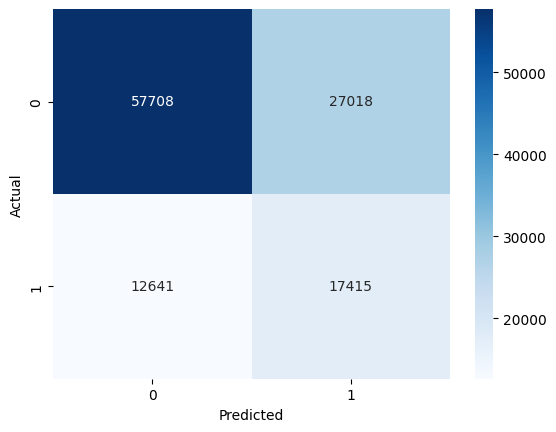

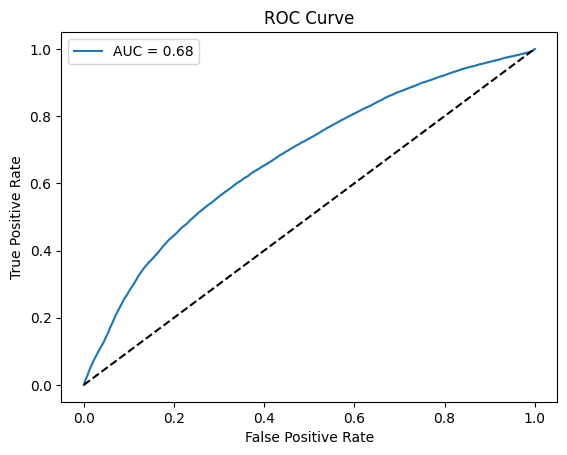

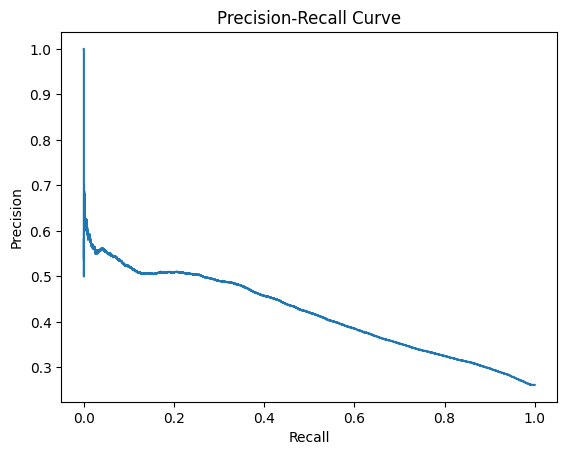

              precision    recall  f1-score   support

 Not Spoiler       0.82      0.68      0.74     84726
     Spoiler       0.39      0.58      0.47     30056

    accuracy                           0.65    114782
   macro avg       0.61      0.63      0.61    114782
weighted avg       0.71      0.65      0.67    114782



In [22]:
# Predict raw probabilities
y_pred_prob = lstm_model.predict(x_test_padded, verbose = 1).flatten()

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 2️⃣ Recall 
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# 3️⃣ Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 4️⃣ F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# 5️⃣ F2 score (more weight on recall)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2)

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix nicely
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7️⃣ ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8️⃣ Precision-Recall Curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# 9️⃣ Classification Report
report = classification_report(y_test, y_pred, target_names = ['Not Spoiler', 'Spoiler'])
print(report)

##### **Undersampling**

3587/3587 ━━━━━━━━━━━━━━━━━━━━ 396s 110ms/step
Accuracy: 0.6545364255719538
Recall: 0.654711205749268
Precision: 0.4019774069004964
F1 Score: 0.49812046728853676
F2 Score: 0.5815802384484888
Confusion Matrix:
 [[55451 29275]
 [10378 19678]]


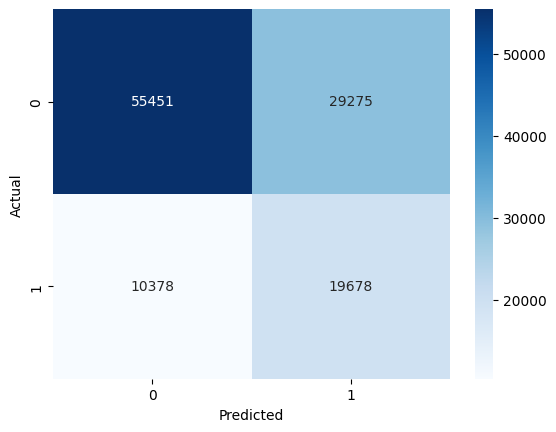

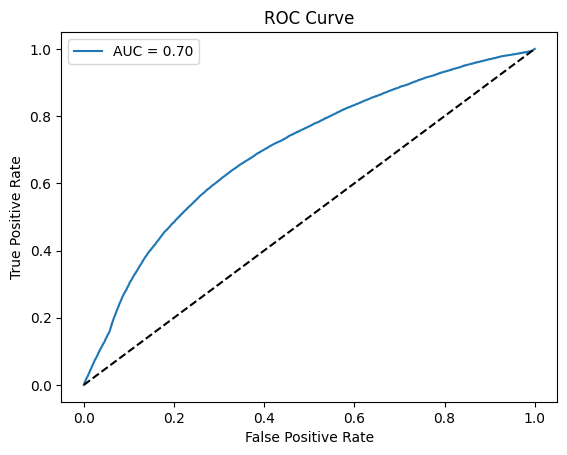

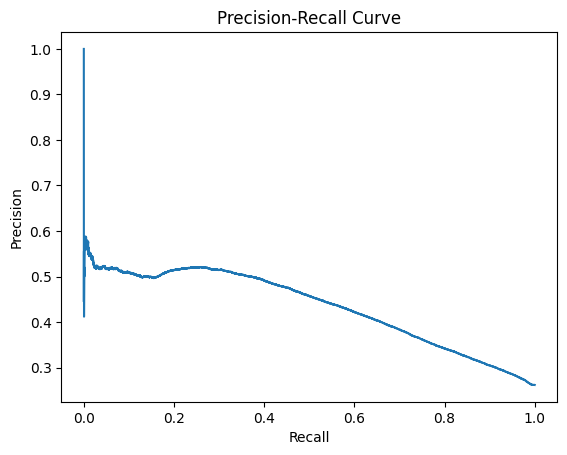

              precision    recall  f1-score   support

 Not Spoiler       0.84      0.65      0.74     84726
     Spoiler       0.40      0.65      0.50     30056

    accuracy                           0.65    114782
   macro avg       0.62      0.65      0.62    114782
weighted avg       0.73      0.65      0.67    114782



In [18]:
# Predict raw probabilities
y_pred_prob = lstm_model.predict(x_test_padded, verbose = 1).flatten()

# Convert probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 2️⃣ Recall 
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# 3️⃣ Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# 4️⃣ F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# 5️⃣ F2 score (more weight on recall)
f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2)

# 6️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix nicely
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7️⃣ ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8️⃣ Precision-Recall Curve
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# 9️⃣ Classification Report
report = classification_report(y_test, y_pred, target_names = ['Not Spoiler', 'Spoiler'])
print(report)